In [1]:
import pandas as pd
import warnings
from performance_utils import calc_metrics, get_roc_auc
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

wv = pd.read_csv('data/word2vec_100.csv')
sg = pd.read_csv('data/skipgram_100.csv')
ft = pd.read_csv('data/fasttext_100.csv')

In [2]:
scores_data = []

# Using CNN

### CBOW

2024-03-18 21:54:20.974378: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-18 21:54:20.974414: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-18 21:54:20.974422: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-18 21:54:20.974449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 21:54:20.974462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-03-18 21:54:21.652541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-18 21:54:21.685011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


732/732 [==============================] - 12s 16ms/step - loss: 117876008.0000 - accuracy: 0.4991 - val_loss: 232644128.0000 - val_accuracy: 0.1428
Epoch 2/10
732/732 [==============================] - 12s 16ms/step - loss: 181264128.0000 - accuracy: 0.5134 - val_loss: 43110804.0000 - val_accuracy: 0.8682
Epoch 3/10
732/732 [==============================] - 12s 16ms/step - loss: 127964640.0000 - accuracy: 0.5201 - val_loss: 48325748.0000 - val_accuracy: 0.8682
Epoch 4/10
732/732 [==============================] - 12s 16ms/step - loss: 81571776.0000 - accuracy: 0.6404 - val_loss: 12136499.0000 - val_accuracy: 0.8875
Epoch 5/10
732/732 [==============================] - 11s 16ms/step - loss: 227876000.0000 - accuracy: 0.6908 - val_loss: 116741144.0000 - val_accuracy: 0.8772
Epoch 6/10
732/732 [==============================] - 12s 16ms/step - loss: 207888864.0000 - accuracy: 0.7085 - val_loss: 419073632.0000 - val_accuracy: 0.4889
Epoch 7/10
732/732 [==============================] - 1

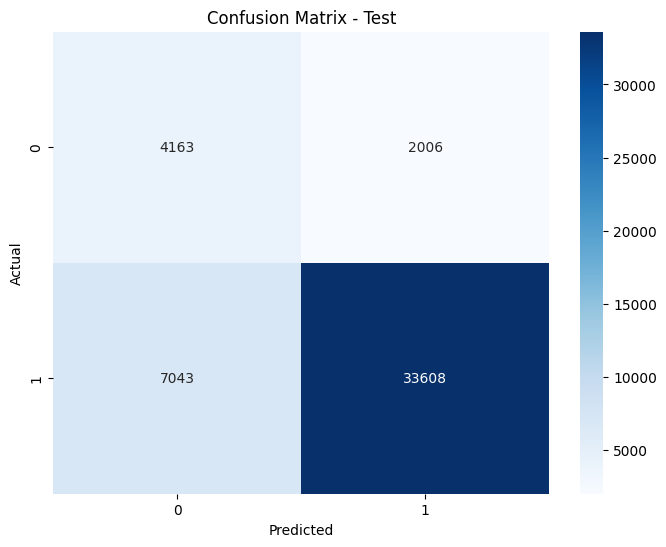

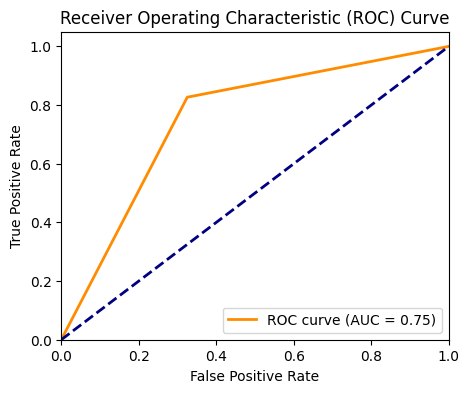

In [3]:
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import set_random_seed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

set_random_seed(80)

X = wv.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = wv['overall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

cw = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
class_weights = {np.unique(y_train)[0]: cw[0], np.unique(y_train)[1]: cw[1]} 

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Adjust layer size based on your needs
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.3), metrics=['accuracy'] )


X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)


model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), class_weight=class_weights)


yhat_probs = model.predict(X_test, verbose=0)
yhat_probs = yhat_probs[:, 0]
y_pred = pd.Series(yhat_probs).apply(lambda x: 1 if x > 0.5 else 0)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)

roc_auc = get_roc_auc(y_test, yhat_probs)

scores_data.append(['CNN', 'CBOW']+[accuracy, precision, recall, f1, roc_auc])

### Skipgram

Epoch 1/10
   1/1464 [..............................] - ETA: 9:56 - loss: 6.8209 - accuracy: 0.8594

2024-03-18 21:56:21.938179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 19s 12ms/step - loss: 23050.4492 - accuracy: 0.5865 - val_loss: 1531.7067 - val_accuracy: 0.8682
Epoch 2/10
1464/1464 [==============================] - 17s 12ms/step - loss: 12249.7373 - accuracy: 0.5053 - val_loss: 17768.9062 - val_accuracy: 0.1318
Epoch 3/10
1464/1464 [==============================] - 17s 12ms/step - loss: 10804.4658 - accuracy: 0.5010 - val_loss: 11701.1904 - val_accuracy: 0.8682
Epoch 4/10
1464/1464 [==============================] - 17s 12ms/step - loss: 11073.0059 - accuracy: 0.5118 - val_loss: 3142.9031 - val_accuracy: 0.8682
Epoch 5/10
1464/1464 [==============================] - 17s 12ms/step - loss: 12789.1543 - accuracy: 0.5116 - val_loss: 1438.8674 - val_accuracy: 0.8683
Epoch 6/10
1464/1464 [==============================] - 17s 12ms/step - loss: 9658.7422 - accuracy: 0.5205 - val_loss: 33357.8164 - val_accuracy: 0.1332
Epoch 7/10
1464/1464 [==============================] - 17s 12ms/step - loss: 8559.1523 - a

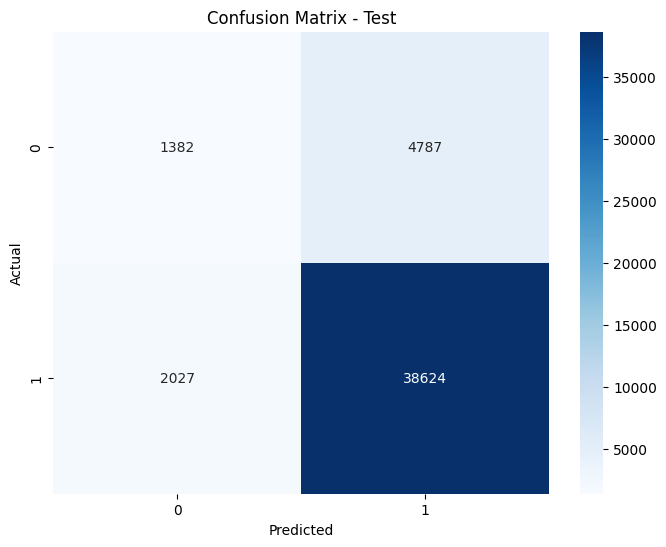

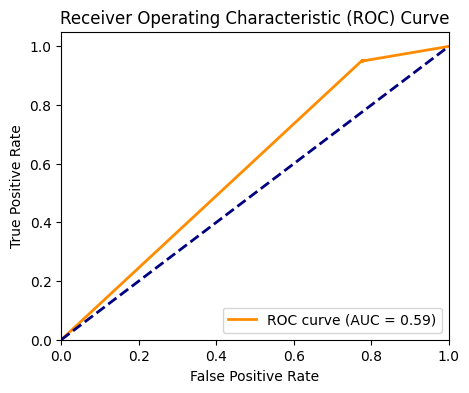

In [4]:
set_random_seed(24)

X = sg.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = sg['overall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Adjust layer size based on your needs
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.1), metrics=['accuracy'] )


X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)


model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weights)


yhat_probs = model.predict(X_test, verbose=0)
yhat_probs = yhat_probs[:, 0]
y_pred = pd.Series(yhat_probs).apply(lambda x: 1 if x > 0.5 else 0)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)

roc_auc = get_roc_auc(y_test, yhat_probs)

scores_data.append(['CNN', 'Skipgram']+[accuracy, precision, recall, f1, roc_auc])

### Fasttext

Epoch 1/10
   1/1464 [..............................] - ETA: 9:57 - loss: 9.0152 - accuracy: 0.8672

2024-03-18 21:59:20.397570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 18s 12ms/step - loss: 3.6263 - accuracy: 0.7028 - val_loss: 0.3512 - val_accuracy: 0.8524
Epoch 2/10
1464/1464 [==============================] - 17s 12ms/step - loss: 1.2968 - accuracy: 0.7101 - val_loss: 0.3284 - val_accuracy: 0.8994
Epoch 3/10
1464/1464 [==============================] - 17s 12ms/step - loss: 0.9696 - accuracy: 0.7330 - val_loss: 0.3244 - val_accuracy: 0.8975
Epoch 4/10
1464/1464 [==============================] - 17s 12ms/step - loss: 0.8927 - accuracy: 0.7333 - val_loss: 0.5254 - val_accuracy: 0.8008
Epoch 5/10
1464/1464 [==============================] - 17s 12ms/step - loss: 0.9073 - accuracy: 0.7354 - val_loss: 0.3878 - val_accuracy: 0.8939
Epoch 6/10
1464/1464 [==============================] - 17s 12ms/step - loss: 0.9523 - accuracy: 0.7326 - val_loss: 0.3927 - val_accuracy: 0.8943
Epoch 7/10
1464/1464 [==============================] - 17s 12ms/step - loss: 1.0325 - accuracy: 0.7295 - val_loss: 1.1213 - val_accura

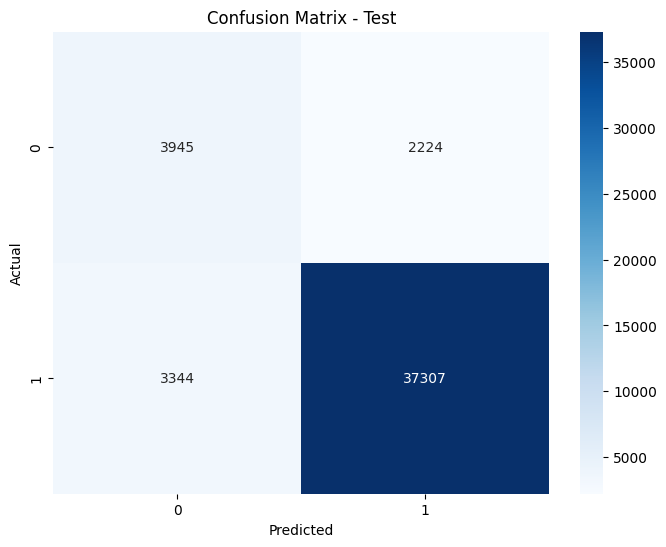

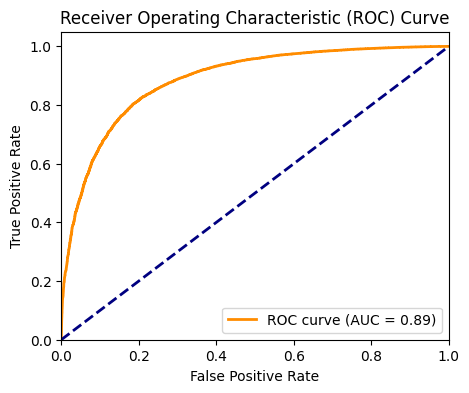

In [5]:
set_random_seed(22)

X = ft.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = ft['overall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Adjust layer size based on your needs
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.01), metrics=['accuracy'] )


X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)


model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weights)


yhat_probs = model.predict(X_test, verbose=0)
yhat_probs = yhat_probs[:, 0]
y_pred = pd.Series(yhat_probs).apply(lambda x: 1 if x > 0.5 else 0)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)

roc_auc = get_roc_auc(y_test, yhat_probs)

scores_data.append(['CNN', 'Fasttext']+[accuracy, precision, recall, f1, roc_auc])


In [6]:
scores = pd.DataFrame(data = scores_data, columns = ['model', 'embedding','accuracy','precision','recall','f1 score','roc auc'])
scores

,model,embedding,accuracy,precision,recall,f1 score,roc auc
0,CNN,CBOW,0.806728,0.943674,0.826745,0.881348,0.750785
1,CNN,Skipgram,0.854464,0.889728,0.950137,0.918941,0.587648
2,CNN,Fasttext,0.881076,0.943740,0.917739,0.930558,0.885207


In [7]:
scores.to_csv('data/CNN_performance.csv', index = False)